In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import re
import preprocessing_mojule 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import preprocessing_mojule as pm
from urllib.request import urlopen
import pickle
import japanize_matplotlib 

In [41]:
url = "https://db.netkeiba.com/race/"

def scraping_horse_ped(horse_id_dic, pre_horse_ped_dic={}):
    horse_ped_dic = pre_horse_ped_dic.copy()
    for horse_id, url in tqdm(horse_id_dic.items()):
        try:
            if horse_id in horse_ped_dic.keys():
                continue
            time.sleep(1)
            res = requests.get(url)
            res.encoding = "EUC-JP"
            soup = BeautifulSoup(res.text, "html.parser")
            li = soup.find("dd", attrs={"class":"DB_ProfHead_dd_01"}).find_all("a")
            id_name_list = []
            for i in li:
                horse_name = i.get_text()
                horse_parent_id = str(i).split("/")[3]
                id_name_list.append((horse_parent_id, horse_name))
            dic = {}
            dic["1_parent"] = (id_name_list[0], id_name_list[3])
            dic["2_parent"] = (id_name_list[1], id_name_list[2], id_name_list[4], id_name_list[5])
            horse_ped_dic[horse_id] = dic
        except Exception as e:
            print(e)
            break
    return horse_ped_dic   

def scraping_results(race_url_dic , pre_race_results={}):
    time.sleep(0.5)
    race_results = pre_race_results.copy()
    for race_id, race_url in tqdm(race_url_dic.items()):
        #time.sleep(1)
        if race_id in race_results.keys():
            continue
        
        try:
            df_tmp = pd.read_html(race_url)[0]
            res = requests.get(race_url)
            res.encoding = "EUC-JP"
            soup = BeautifulSoup(res.text, "html.parser")
            texts_horse = soup.find("table", summary="レース結果").find_all("a", attrs={"href":re.compile("/horse")})
            texts_jockey = soup.find("table", summary="レース結果").find_all("a", attrs={"href":re.compile("/jockey")})
            horse_ids = []
            jockey_ids = []
            for text in texts_horse:
                horse_id = re.findall("\d+", text["href"])[0]
                horse_ids.append(horse_id)
            for text in texts_jockey:
                jockey_id = re.findall("\d+", text["href"])[0]
                jockey_ids.append(jockey_id) 
            df_tmp["horse_id"] = horse_ids
            df_tmp["jockey_id"] = jockey_ids
            race_results[race_id] = df_tmp
        except UnicodeDecodeError:
            continue
        except IndexError:
            continue
        except:
            print(race_url)
            break 
    return race_results       

def make_url():
    url = "https://db.netkeiba.com/race/"
    race_url_dic = {}
    for place in range(1, 11):
        for kai in range(1, 6):
            for day in range(1, 13):
                for race in range(1, 13):
                    race_id = str(2023) + str(place).zfill(2) + str(kai).zfill(2) + str(day).zfill(2) + str(race).zfill(2)
                    race_url_dic[race_id] = url + race_id
    return race_url_dic            

def dic_to_df(dic):
    dic_tmp = dic.copy()
    for key in dic_tmp:
        dic_tmp[key].index = [key] * len(dic_tmp[key])
    df = pd.concat([dic_tmp[key] for key in dic_tmp], sort=False)
    return df

def horse_pre_prizes_ave(x, gap=365):
    horse_id = x["horse_id"]
    today = x["date"]
    first = True
    try:
        if horse_id not in dict_horse_history.keys():
            return 0
        df_horse = dict_horse_history[horse_id]
        if isinstance(df_horse, pd.Series):
            if today - df_horse["日付"] > timedelta(gap) or today <= df_horse["日付"]:
                return 0
            else:
                average_prize = df_horse["賞金"]
        else:
            df_horse_present = df_horse[today - df_horse["日付"] <= timedelta(gap)]
            df_horse_present = df_horse_present[today - df_horse_present["日付"] > timedelta(0)]
            df_horse_present_prize = df_horse_present["賞金"]
            average_prize = df_horse_present_prize.mean()
        if np.isnan(average_prize):
            return 0
        else:
            return average_prize
    except KeyError:
        if first:
            first = False
            print(f"エラー race_id = {race_id}, horse_id = {horse_id}, today = {today}")
        return 0

def horse_pre_prizes_sum(x, gap=365):
    horse_id = x["horse_id"]
    today = x["date"]
    first = True
    try:
        if horse_id not in dict_horse_history.keys():
            return 0
        df_horse = dict_horse_history[horse_id]

        if isinstance(df_horse, pd.Series):
            if df_horse["日付"] >= today or today - df_horse["日付"] > timedelta(gap):
                return 0
            else:
                average_prize = df_horse["賞金"]
        else:
            df_horse_present = df_horse[today - df_horse["日付"] <= timedelta(gap)]
            df_horse_present = df_horse_present[today - df_horse_present["日付"] > timedelta(0)]
            df_horse_present_prize = df_horse_present["賞金"]
            average_prize = df_horse_present_prize.sum()

        if np.isnan(average_prize):
            return 0

        else:
            return average_prize
    except KeyError:
        if first:
            first = False
            print(f"エラー race_id = {race_id}, horse_id = {horse_id}, today = {today}")
        return 0   


def horse_pre_order_ave(x, gap=365):
    def to_int(s):
        try:
            int(s)
            return int(s)
        except ValueError:
            return substitute_num
        
    substitute_num = (sum([i+1 for i in range(16)])/16 + sum([i+1 for i in range(9)])/9) / 2
    horse_id = x["horse_id"]
    today = x["date"]
    first = True
    try:
        if horse_id not in dict_horse_history.keys():
            return substitute_num
        df_horse = dict_horse_history[horse_id]

        if isinstance(df_horse, pd.Series):
            if df_horse["日付"] >= today or today - df_horse["日付"] > timedelta(gap):
                return substitute_num
            else:
                average_order = to_int(df_horse["着順"])
                
        else:
            df_horse_present = df_horse[today - df_horse["日付"] <= timedelta(gap)]
            df_horse_present = df_horse_present[today - df_horse_present["日付"] > timedelta(0)]
            df_horse_present_order = df_horse_present["着順"]
            #df_horse_heads = df_horse_present["頭数"]
            df_horse_present_order = df_horse_present_order.map(lambda x:to_int(x))
            #df_horse_heads = df_horse_heads.map(lambda x:to_int(x))
            #df_horse_present_order = df_horse_present_order[df_horse_heads > 0]
            #df_horse_heads = df_horse_heads[df_horse_heads > 0]
            #average_order = df_horse_present_order / df_horse_heads
            average_order = df_horse_present_order.mean()
            

        if np.isnan(average_order):
            return substitute_num

        else:
            return average_order
    except KeyError:
        if first:
            first = False
            print(f"エラー race_id = {race_id}, horse_id = {horse_id}, today = {today}")
        return substitute_num
    

class Results:
    def __init__(self, pre_df):
        self.pre_df = pre_df
        self.before_scale = None
        self.post_df = self.preprocessing(self.pre_df)
        
    
    def preprocessing(self, pre_df):
        results = pre_df.copy()
        results = results[~(results["着順"].astype(str).str.contains("\D"))]
        results["着順"] = results["着順"].astype(int)
        results["性齢"] = results["性齢"].astype(str)
        results["性"] = results["性齢"].map(lambda x:x[0])
        results["年齢"] = results["性齢"].map(lambda x:x[1:])
        results["体重"] = results["馬体重"].map(lambda x:x[:3])
        results["増減"] = results["馬体重"].str.split("(").map(lambda x:int(x[-1][:-1]))
        results["人気"] = results["人気"].astype(int)
        results["年齢"] = results["年齢"].astype(int)
        results["体重"] = results["体重"].astype(float)
        results["単勝"] = results["単勝"].astype(float)
        results = pd.concat([results, pd.get_dummies(results["性"])], axis=1)
        results["勝率*騎乗回数"] = results["勝率"] * results["騎乗回数"]
        results["連対率*騎乗回数"] = results["連対率"] * results["騎乗回数"]
        results["複勝率*騎乗回数"] = results["複勝率"] * results["騎乗回数"]
        
        
        results["増減/体重"] = results["増減"] / results["体重"]  
        results["斤量/体重"] = results["斤量"] / results["体重"]
        
        features_addinfo = [
            '着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手', 'タイム', '着差', '単勝', '人気',
       '馬体重', '調教師', 'horse_id', 'jockey_id', 'length', 'race_type', 'weather',
       'condition', 'date', '騎乗回数', '勝率', '連対率', '複勝率', '賞金_ave', '賞金_sum',
       '順番_ave', '賞金_ave_2', '賞金_sum_2', '順番_ave_2', '賞金_ave_4', '賞金_sum_4',
       '順番_ave_4', '順番_ave_distorted', '順番_ave_2_distorted',
       '順番_ave_4_distorted', '芝', 'ダ', '障', '短距離', 'マイル距離', '芝_ave_order',
       'ダ_ave_order', '短距離_ave_order', 'マイル距離_ave_order', '芝得意', '短距離得意',
       '中距離_ave_order', '長距離_ave_order', 'マイル距離得意', '中距離得意', '長距離得意',
       'length_match', 'race_type_match'
        ]
        
        drop_features = [
            "枠番", "馬名", "性齢", "騎手", "タイム", "着差", "人気", "馬体重", "調教師", "horse_id",
            "jockey_id", "length", "race_type", "weather", "condition", "date", "性",
            '芝', 'ダ', '障', '短距離', 'マイル距離', '芝_ave_order',
            'ダ_ave_order', '短距離_ave_order', 'マイル距離_ave_order', '芝得意', '短距離得意',
            '中距離_ave_order', '長距離_ave_order', 'マイル距離得意', '中距離得意', '長距離得意',
        ]
        results = results.drop(drop_features, axis=1)
        results = results.astype(float)
        results["着順"] = results["着順"].astype(int)
        self.before_scale = results
        
        keep_features = ['着順', 'セ', '牝', '牡', "馬番", "length_match", "race_type_match"]
        scaler = pm.CustomSTDScaler(keep_features)
        results = scaler.fit_transform(results)
    
        return results
 

def scraping_infos(race_url_dic , pre_race_infos={}):
    time.sleep(1)
    race_infos = pre_race_infos.copy()
    for race_id, race_url in tqdm(race_url_dic.items()):
        if race_id in race_infos.keys():
            continue
        try:
            res = requests.get(race_url)
            res.encoding = "EUC-JP"
            soup = BeautifulSoup(res.text, "html.parser")
            texts = soup.find("div", attrs={"class":"data_intro"}).find_all("p")[0].get_text() + soup.find("div", attrs={"class":"data_intro"}).find_all("p")[1].get_text()
            texts = re.findall(r"\w+", texts)
            race_infos[race_id] = {}
            for idx, text in enumerate(texts):
                if text in ["芝" , "ダート"]:
                    race_infos[race_id]["condition"] = texts[idx + 1]
                if text in ["天候"]:
                    race_infos[race_id]["weather"] = texts[idx + 1]
                for date in [str(i) for i in range(2000, 2025)]:
                    if date in text:
                        race_infos[race_id]["date"] = text
                if "m" in text:
                    race_infos[race_id]["length"] = text[-5:-1]
                if "race_type" in race_infos[race_id].keys() and race_infos[race_id]["race_type"] == "障":
                    continue
                for race_type in ["障", "芝", "ダート"]:
                    if race_type in text:
                        race_infos[race_id]["race_type"] = race_type

        except UnicodeDecodeError:
            continue
        except AttributeError:
            continue
        except:
            print(race_url)
            break 
    return race_infos 

def scraping_horse(horse_id_dic, pre_horse_history={}):
    horse_history = pre_horse_history.copy()
    time.sleep(1)
    for horse_id, horse_url in tqdm(horse_id_dic.items()):
        tmp_df = pd.read_html(horse_url)[3]
        horse_history[horse_id] = tmp_df
    return horse_history    

def make_horse_url(horse_id_list):
    horse_id_dic = {}
    for horse_id in horse_id_list:
        horse_url = "https://db.netkeiba.com/" + "horse/" + str(horse_id)
        horse_id_dic[horse_id] = horse_url
        
    return horse_id_dic

def scraping_jockey(jockey_id_dic, pre_jockey_history):
    jockey_history = pre_jockey_history.copy()
    for jockey_id, jockey_url in tqdm(jockey_id_dic.items()):
        time.sleep(1)
        tmp_df = pd.read_html(jockey_url)[2]
        jockey_history[jockey_id] = tmp_df
        
    return jockey_history    

def make_jockey_url(jockey_id_list):
    jockey_id_dic = {}
    for jockey_id in jockey_id_list:
        jockey_url = "https://db.netkeiba.com/" + "jockey/" + str(jockey_id)
        jockey_id_dic[jockey_id] = jockey_url
        
    return jockey_id_dic   

def scraping_pay(race_url_dic, pre_pay={}):
    pay = pre_pay.copy()
    for race_id, url in tqdm(race_url_dic.items()):
        if race_id in pay.keys():
            continue
        
        try:
            time.sleep(0.1)
            f = urlopen(url)
            html = f.read()
            html = html.replace(b"<br />", b"br")
            df = pd.concat([pd.read_html(html)[1], pd.read_html(html)[2]], axis=0)
            df.columns = ["種類", "該当馬", "金", "人気"]
            df.set_index("種類", inplace=True)
            df["人気"] = df["人気"].map(lambda x:re.split("br|-|→", x))
            df["該当馬"] = df["該当馬"].map(lambda x:re.split("br|-|→", x))
            df["金"] = df["金"].map(lambda x:re.split("br|-|→", x))
            pay[race_id] = df
        except UnicodeDecodeError:
            print((race_id, url))
            continue
        except IndexError:
            print((race_id, url))
            continue
        except:
            print((race_id, url))
            break
    return pay

class Evaluater():
    def __init__(self, X, y):
        train_x, self.__X_test, train_y, self.__y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
        self.__X_train, self.__X_val, self.__y_train, self.__y_val = train_test_split(train_x, train_y, test_size=0.3, shuffle=False)
        self.__params = None
        self.__params = self.params
        self.__model = self.model
        return 
    @property
    def params(self):
        if self.__params == None:
            param = {
                'objective': 'binary',
                 'random_state': 57,
                 'metric': 'auc',
                 'feature_pre_filter': False,
                 'lambda_l1': 9.926347819260023,
                 'lambda_l2': 0.2635745692891133,
                 'num_leaves': 2,
                 'feature_fraction': 0.48000000000000004,
                 'bagging_fraction': 1.0,
                 'bagging_freq': 0,
                 'min_child_samples': 20,
                 'num_iterations': 1000
            }
         
        self.__params = param
        return self.__params
    @params.setter
    def params(self, params):
        self.__params = params
        self.__model = lgb.LGBMClassifier(**self.__params, verbose=-1)
    @property
    def model(self):
        self.__model = lgb.LGBMClassifier(**self.__params, verbose=-1)
        return self.__model
    @property
    def X_test(self):
        return self.__X_test
    def predict(self,X_test, threshold=0.5):
        self.fit()
        pred = self.predict_proba(X_test, threshold)
        pred = np.array([1 if p >= threshold else 0 for p in pred])
        return pred
    def predict_proba(self, X_test, threshold=0.5):
        self.fit()
        pred = self.__model.predict_proba(X_test.drop(["馬番", "単勝"], axis=1, inplace=False)).T[1]
        df = X_test.copy()
        df["proba"] = pred
        df["mean"] = df.groupby(df.index)["proba"].transform("mean")
        df["std"] = df.groupby(df.index)["proba"].transform("std")
        df["min"] = df.groupby(df.index)["proba"].transform("min")
        df["max"] = df.groupby(df.index)["proba"].transform("max")
        df["scale_standard"] = (df["proba"] - df["mean"]) / df["std"]
        df["scale_minmax"] = (df["proba"] - df["min"]) / (df["max"] - df["min"])
        return df["scale_standard"]
    def fit(self):
        verbose_eval = -1
        self.__model = self.__model.fit(self.__X_train.drop(["馬番", "単勝"], axis=1, inplace=False), self.__y_train,
                 eval_set=[(self.__X_val.drop(["馬番", "単勝"], axis=1, inplace=False), self.__y_val)],
                 callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False), 
                            lgb.log_evaluation(verbose_eval),
                          ] 
                 )
        return self.__model
    def f1_score_cal(self,threshold=0.5):
        pred = self.predict(self.__X_test, threshold)
        return f1_score(self.__y_test, pred)
    def acc_cal(self, threshold=0.5):
        pred = self.predict(self.__X_test, threshold)
        return accuracy_score(self.__y_test, pred)
    def importance(self):
        self.fit()
        importances = pd.DataFrame(
            {
                "features":self.__X_train.drop(["馬番", "単勝"], axis=1, inplace=False).columns, "importance":self.__model.feature_importances_
            })
            
        importances =  importances.sort_values("importance", ascending=False)
        return importances
    def cal(self, X_test, pay_dict, threshold=0.5, fukusho=False, balanced=True):
        def cal_payment(x):
            race_id = x.name
            horse_number = str(int(x[0]))
            odds = x[1]
            df = pay_dict[race_id]
            df_fukusho = df.loc["複勝"]
            df_tansho = df.loc["単勝"]
            money = 0
            if balanced == False:
                if horse_number in df_fukusho["該当馬"] and fukusho:
                    idx = df_fukusho["該当馬"].index(horse_number)
                    tmp = df_fukusho["金"][idx]
                    tmp = tmp.split(",")
                    money = int("".join(tmp))
                if horse_number in df_tansho["該当馬"] and fukusho == False:
                    tmp = df_tansho["金"][0]
                    tmp = tmp.split(",")
                    money = int("".join(tmp))
            else:
                if horse_number in df_fukusho["該当馬"] and fukusho:
                    idx = df_fukusho["該当馬"].index(horse_number)
                    tmp = df_fukusho["金"][idx]
                    tmp = tmp.split(",")
                    odds_post = int("".join(tmp))
                    n_parchased = 10000 // (odds*0.5*100)
                    money = n_parchased * odds_post 
                if horse_number in df_tansho["該当馬"] and fukusho == False:
                    tmp = df_tansho["金"][0]
                    tmp = tmp.split(",")
                    odds_post = int("".join(tmp))
                    n_parchased = 10000 // (odds*100)
                    money = n_parchased * odds_post 
                    
            return money
        def cal_invested(x):
            race_id = x.name
            horse_number = str(int(x[0]))
            odds = x[1]
            if fukusho == False:
                n_parchased = 10000 // (odds*100)
            else:
                n_parchased = 10000 // (odds*0.5*100)
            invested = n_parchased * 100    
            return invested
            
        pred = self.predict(X_test, threshold)
        parchaced = X_test[pred==1][["馬番", "単勝"]]
        payback = parchaced.apply(lambda x:cal_payment(x), axis=1)
        payback_sum = np.sum(payback.values, axis=0)
        if balanced == False:
            invested = 100 * parchaced.shape[0]
        else:
            tmp = parchaced.apply(lambda x:cal_invested(x), axis=1)
            invested = np.sum(tmp.values, axis=0)
        div = payback_sum - invested
        if isinstance(invested, (int, float)):
            if invested == 0:
                div = 0
                payback_sum = 0
        else:
            invested = 0
            div = 0
            payback_sum = 0
            
        return invested, payback_sum, payback
    def visualize(self, X_test, bins=100, fukusho=False, balanced=True):
        thresholds = []
        kaishuuritu = []
        div = []
        investeds = []
        stds = []
        res = {}
        for i in tqdm(range(bins+2)):
            threshold = -1 + (i/bins)*3
            thresholds.append(threshold)
            invested, payback_sum, payback = self.cal(X_test, pay_dict, threshold, fukusho, balanced)
            std = payback.std() / np.sqrt(payback.shape[0])
            div.append(payback_sum - invested)
            investeds.append(invested/100)
            if invested == 0:
                if payback_sum == 0:
                    kaishuuritu.append(1*100)    
                stds.append(stds[-1])
                continue
            stds.append(std)    
            kaishuuritu.append((payback_sum / invested)*100)
        res["invested"] = np.array(investeds)
        res["kaishuuritu"] = np.array(kaishuuritu)
        res["div"] = np.array(div)
        res["threshold"] = np.array(thresholds)
        res["std"] = np.array(stds)
        self.__d = res["invested"]
        self.__h = res["kaishuuritu"]
        return res   
    def integral(self, d=None, h=None, bins=100, fukusho=True):
        def private_integral(x, y):
            z = [(d, h) for d, h in zip(x, y)]
            z.sort()
            x = np.array([i[0] for i in z])
            x = x/max(x)
            y = np.array([i[1] for i in z])
            y = y - 100

            length = x.shape[0]
            S = 0
            for i in range(length - 1):
                d = x[i + 1] - x[i]
                a = y[i]
                b = y[i + 1]
                s = (y[i] + y[i + 1]) * d / 2
                S += s
            return S   
        if d is None is h == None:
            res = self.visualize(self.X_test, bins=bins, fukusho=fukusho)
            d, h = res["invested"], res["kaishuuritu"]
        return private_integral(d, h)

In [3]:
results_addinfo = pd.read_pickle("result_addinfo.pickle")
horse_history = pd.read_pickle("horse_history.pickle")
jockey_history = pd.read_pickle("jockey_history.pickle")
dict_horse_history = {idx: horse_history.loc[idx] for idx in horse_history.index.unique()}

with open("pay_dict.pickle", "rb") as f:
    pay_dict = pickle.load(f)
with open("dict_horse_ped.pickle", "rb") as f:
    horse_ped_dict = pickle.load(f)

In [42]:
instance = Results(results_addinfo)
data = instance.post_df
th = 3
X, y = data.drop(["着順"], axis=1), data["着順"].map(lambda x:1 if -(x-th) >= 0 else 0)

drop_features = [
       '連対率', 
        '賞金_ave_2', '賞金_sum_2',  '賞金_ave_4', '賞金_sum_4',
        '順番_ave_4', '順番_ave_distorted', '順番_ave_2_distorted',
        '順番_ave_4_distorted',
        '増減',  '勝率*騎乗回数',
        '連対率*騎乗回数', '複勝率*騎乗回数',
]
X.drop(drop_features, axis=1, inplace=True)

In [43]:
ev = Evaluater(X, y)

In [44]:
ev.importance()

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


,features,importance
4,賞金_ave,57
6,順番_ave,51
3,複勝率,42
11,年齢,34
7,順番_ave_2,25
0,斤量,22
8,length_match,17
17,斤量/体重,17
5,賞金_sum,11
16,増減/体重,11


In [45]:
dic2 = ev.visualize(ev.X_test, fukusho=False, bins=30, balanced=False)

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` i

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` i

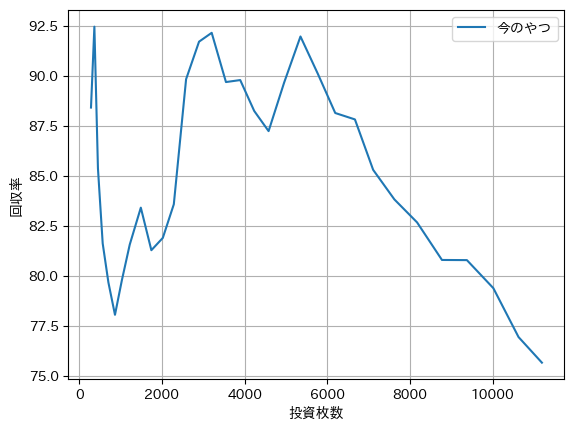

In [46]:
a = 0
#plt.plot(dic3["invested"], dic3["kaishuuritu"], label="前のやつ")
plt.plot(dic2["invested"], dic2["kaishuuritu"], label="今のやつ")
#plt.fill_between(dic["invested"], dic["kaishuuritu"] - a*dic["std"], dic["kaishuuritu"] + a*dic["std"], alpha=0.2)
plt.legend()
plt.xlabel("投資枚数")
plt.ylabel("回収率")
plt.grid()
plt.show()

In [159]:
thresholds = []
accs = []
f1s = []
for i in tqdm(range(12)):
    th = i / 10
    thresholds.append(th)
    acc = ev.acc_cal(th)
    f1 = ev.f1_score_cal(th)
    accs.append(acc)
    f1s.append(f1)

  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` i

In [573]:
tmp_x, y_train, tmp_y, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(tmp_x, tmp_y, test_size=0.3, shuffle=False)

In [574]:
import optuna.integration.lightgbm as lgb_o
lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_val = lgb_o.Dataset(X_val.values, y_val.values)

In [575]:
params = {
    "objective":"binary",
    "random_state":57,
    "metric":"auc"
}

lgb_clf_o = lgb_o.train(params, 
                        lgb_train, valid_sets=(lgb_train, lgb_val),
                       )


[I 2023-12-18 02:59:37,118] A new study created in memory with name: no-name-b7603ce8-5ec8-4041-859a-d896353c6308
feature_fraction, val_score: -inf:   0%|                                                         | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


feature_fraction, val_score: 0.803047:  14%|######4                                      | 1/7 [00:05<00:31,  5.30s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


feature_fraction, val_score: 0.803047:  29%|############8                                | 2/7 [00:10<00:27,  5.41s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


feature_fraction, val_score: 0.803047:  43%|###################2                         | 3/7 [00:16<00:22,  5.55s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


feature_fraction, val_score: 0.803047:  57%|#########################7                   | 4/7 [00:22<00:17,  5.77s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


feature_fraction, val_score: 0.803047:  71%|################################1            | 5/7 [00:28<00:11,  5.91s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


feature_fraction, val_score: 0.803047:  86%|######################################5      | 6/7 [00:35<00:06,  6.05s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.803047:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.803047:   5%|##5                                               | 1/20 [00:07<02:24,  7.58s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.803047:  10%|#####                                             | 2/20 [00:20<03:09, 10.52s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.803047:  15%|#######5                                          | 3/20 [00:29<02:48,  9.92s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.803047:  20%|##########                                        | 4/20 [00:46<03:22, 12.67s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.804546:  25%|############5                                     | 5/20 [00:50<02:25,  9.68s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.809334:  30%|###############                                   | 6/20 [00:54<01:48,  7.73s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.809334:  35%|#################5                                | 7/20 [00:59<01:28,  6.83s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.809334:  40%|####################                              | 8/20 [01:03<01:11,  5.92s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.809334:  45%|######################5                           | 9/20 [01:08<01:00,  5.47s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.809334:  50%|########################5                        | 10/20 [01:15<00:59,  6.00s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.809334:  55%|##########################9                      | 11/20 [01:27<01:10,  7.79s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.809334:  60%|#############################4                   | 12/20 [01:33<00:59,  7.49s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.809334:  65%|###############################8                 | 13/20 [01:48<01:07,  9.68s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.809334:  70%|##################################3              | 14/20 [01:58<00:58,  9.68s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.809334:  75%|####################################7            | 15/20 [02:02<00:40,  8.01s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.820601:  80%|#######################################2         | 16/20 [02:06<00:26,  6.69s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.820601:  85%|#########################################6       | 17/20 [02:13<00:20,  6.85s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.820601:  90%|############################################1    | 18/20 [02:20<00:13,  6.95s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


num_leaves, val_score: 0.820601:  95%|##############################################5  | 19/20 [02:28<00:07,  7.38s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


bagging, val_score: 0.820601:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


bagging, val_score: 0.820601:  10%|#####3                                               | 1/10 [00:03<00:34,  3.78s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


bagging, val_score: 0.820601:  20%|##########6                                          | 2/10 [00:07<00:30,  3.78s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


bagging, val_score: 0.820601:  30%|###############9                                     | 3/10 [00:11<00:26,  3.77s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


bagging, val_score: 0.820601:  40%|#####################2                               | 4/10 [00:15<00:23,  3.84s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


bagging, val_score: 0.820601:  50%|##########################5                          | 5/10 [00:19<00:19,  3.85s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


bagging, val_score: 0.820601:  60%|###############################8                     | 6/10 [00:22<00:15,  3.82s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


bagging, val_score: 0.820601:  70%|#####################################                | 7/10 [00:26<00:11,  3.77s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


bagging, val_score: 0.820601:  80%|##########################################4          | 8/10 [00:30<00:07,  3.71s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


bagging, val_score: 0.820601:  90%|###############################################7     | 9/10 [00:33<00:03,  3.74s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


feature_fraction_stage2, val_score: 0.820601:   0%|                                              | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


feature_fraction_stage2, val_score: 0.820760:  33%|############6                         | 1/3 [00:03<00:07,  3.51s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


feature_fraction_stage2, val_score: 0.820760:  67%|#########################3            | 2/3 [00:06<00:03,  3.45s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.820760:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.820760:   5%|#9                                    | 1/20 [00:03<01:05,  3.44s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.820760:  10%|###8                                  | 2/20 [00:06<01:01,  3.43s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.820760:  15%|#####7                                | 3/20 [00:10<00:58,  3.43s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.820760:  20%|#######6                              | 4/20 [00:13<00:54,  3.43s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.820760:  25%|#########5                            | 5/20 [00:17<00:51,  3.44s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.820760:  30%|###########4                          | 6/20 [00:20<00:48,  3.44s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.820760:  35%|#############3                        | 7/20 [00:24<00:44,  3.44s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.820760:  40%|###############2                      | 8/20 [00:27<00:41,  3.44s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.820760:  45%|#################1                    | 9/20 [00:30<00:37,  3.42s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.821242:  50%|##################5                  | 10/20 [00:34<00:34,  3.43s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.821621:  55%|####################3                | 11/20 [00:37<00:31,  3.44s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.821621:  60%|######################2              | 12/20 [00:41<00:27,  3.46s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.821621:  65%|########################             | 13/20 [00:44<00:24,  3.46s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.821621:  70%|#########################9           | 14/20 [00:48<00:21,  3.55s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.821621:  75%|###########################7         | 15/20 [00:52<00:17,  3.53s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.821697:  80%|#############################6       | 16/20 [00:55<00:14,  3.52s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.821697:  85%|###############################4     | 17/20 [00:58<00:10,  3.51s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.821697:  90%|#################################3   | 18/20 [01:02<00:06,  3.49s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


regularization_factors, val_score: 0.821697:  95%|###################################1 | 19/20 [01:05<00:03,  3.48s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


min_child_samples, val_score: 0.821697:   0%|                                                    | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


min_child_samples, val_score: 0.821697:  20%|########8                                   | 1/5 [00:03<00:13,  3.45s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


min_child_samples, val_score: 0.821697:  40%|#################6                          | 2/5 [00:06<00:10,  3.46s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


min_child_samples, val_score: 0.821697:  60%|##########################4                 | 3/5 [00:10<00:06,  3.45s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


min_child_samples, val_score: 0.821697:  80%|###################################2        | 4/5 [00:13<00:03,  3.45s/it]

[LightGBM] [Info] Number of positive: 4610, number of negative: 16575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217607 -> initscore=-1.279668
[LightGBM] [Info] Start training from score -1.279668


min_child_samples, val_score: 0.821697: 100%|############################################| 5/5 [00:17<00:00,  3.45s/it]


In [576]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 57,
 'metric': 'auc',
 'feature_pre_filter': False,
 'lambda_l1': 9.926347819260023,
 'lambda_l2': 0.2635745692891133,
 'num_leaves': 2,
 'feature_fraction': 0.48000000000000004,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'num_iterations': 1000}